# Imports 

In [5]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import os
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

# Check GPU

In [6]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        print(gpu.name)
        tf.config.experimental.set_memory_growth(gpu, True)
else:
    print("No gpu devices found")
    

/physical_device:GPU:0
/physical_device:GPU:1


# Constants 

In [7]:
IMG_SIZE = (64, 64)
BATCH_SIZE = 256
NUM_CLASSES = 5 

# Set Directories

In [8]:
train_dir = '/kaggle/input/segmented-dental-radiographyyy/Segmented Dental Radiography/train'
valid_dir = '/kaggle/input/segmented-dental-radiographyyy/Segmented Dental Radiography/valid'
test_dir = '/kaggle/input/segmented-dental-radiographyyy/Segmented Dental Radiography/test'

# Generators

In [9]:
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='sparse'
)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='sparse'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='sparse'
)

Found 25410 images belonging to 5 classes.
Found 2721 images belonging to 5 classes.
Found 1714 images belonging to 5 classes.


# Set Class Weight 
- used class weight since the dataset is highly unbalanced 

In [10]:
train_labels = train_generator.classes
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_labels), y=train_labels)
class_weights = dict(enumerate(class_weights))

# Model 

In [11]:
pretrained_model = DenseNet201(weights='imagenet', include_top=False, input_shape=[*IMG_SIZE, 3])
pretrained_model.trainable = True

inp = Input(shape=(*IMG_SIZE, 3))
densenet = pretrained_model(inp)

X = GlobalAveragePooling2D()(densenet)
X = Dense(256, activation='elu')(X)
X = Dropout(0.3)(X)

X = Dense(128, activation='elu')(X)
X = Dropout(0.2)(X)

X = Dense(32, activation='elu')(X)

out = Dense(NUM_CLASSES, activation='softmax')(X)

model = Model(inputs=inp, outputs=out)

my_callbacks = [
    EarlyStopping(
        min_delta=0.0001, 
        monitor='val_loss', 
        patience=20, 
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor='val_loss', 
        factor=0.1, 
        patience=20
    ),
    ModelCheckpoint(
        filepath='best_model.keras', 
        monitor='val_loss', 
        save_best_only=True, 
        save_weights_only=False  
    )
]

model.compile(optimizer=tf.keras.optimizers.Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


# Training 

In [12]:
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=100,
    class_weight=class_weights,
    callbacks=my_callbacks
)

Epoch 1/100


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1723042576.086737     128 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


  1/100 ━━━━━━━━━━━━━━━━━━━━ 8:31:06 310s/step - accuracy: 0.3828 - loss: 1.3038

W0000 00:00:1723042576.511543     128 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 56/100 ━━━━━━━━━━━━━━━━━━━━ 2:42 4s/step - accuracy: 0.4319 - loss: 1.1930  

W0000 00:00:1723042779.631598     125 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4790 - loss: 1.0420

W0000 00:00:1723042855.624440     125 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


100/100 ━━━━━━━━━━━━━━━━━━━━ 592s 3s/step - accuracy: 0.4797 - loss: 1.0397 - val_accuracy: 0.8170 - val_loss: 1.1584 - learning_rate: 0.0010
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 41s 389ms/step - accuracy: 0.6816 - loss: 0.5280 - val_accuracy: 0.7203 - val_loss: 0.7766 - learning_rate: 0.0010
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 37s 356ms/step - accuracy: 0.7238 - loss: 0.4740 - val_accuracy: 0.8295 - val_loss: 0.9698 - learning_rate: 0.0010
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 37s 353ms/step - accuracy: 0.7678 - loss: 0.3805 - val_accuracy: 0.6038 - val_loss: 1.1530 - learning_rate: 0.0010
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 41s 389ms/step - accuracy: 0.8067 - loss: 0.3058 - val_accuracy: 0.8614 - val_loss: 0.4279 - learning_rate: 0.0010
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 37s 353ms/step - accuracy: 0.8559 - loss: 0.2456 - val_accuracy: 0.7519 - val_loss: 0.7568 - learning_rate: 0.0010
Epoch 8/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 37s 355ms/step - accuracy: 0.8071 - l

# Evaluation

In [13]:
test_loss, test_acc= model.evaluate(test_generator)
print(f"Test loss: {test_loss:.2f}")
print(f"Test accuracy: {test_acc:.2f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 32s 5s/step - accuracy: 0.9010 - loss: 0.3342 
Test loss: 0.33
Test accuracy: 0.90


W0000 00:00:1723044561.219621     127 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


# Plotting 

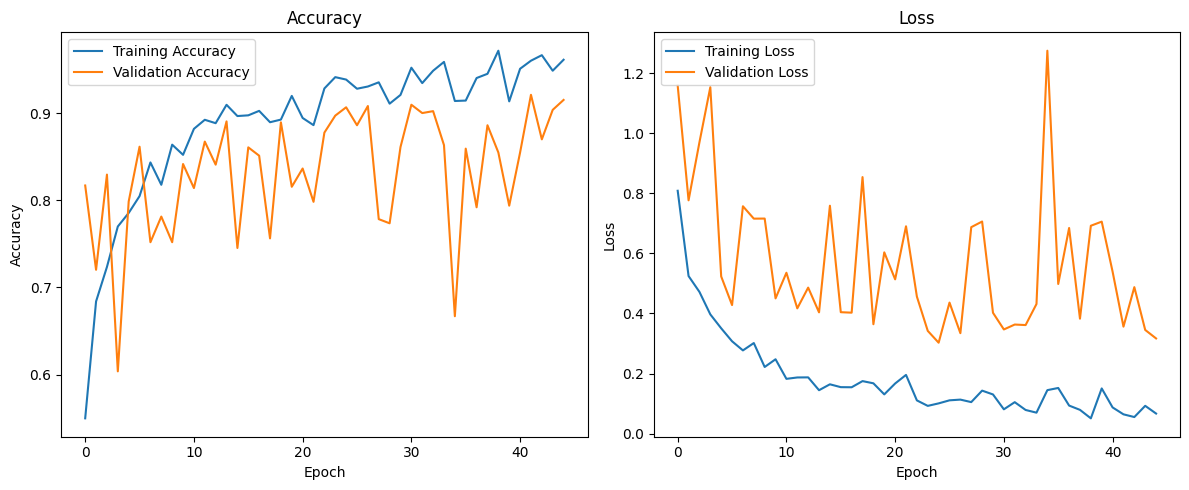

In [14]:
history_dict = history.history

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_dict['accuracy'], label='Training Accuracy')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Confusion Matrix Function

In [15]:
def plot_confusion_matrix(cm, class_names, title='Confusion Matrix'):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Function for Getting Labels and Predictions 

In [16]:
def get_predictions_and_labels(generator):
    num_samples = generator.samples
    predictions = []
    labels = []
    
    # Reset generator to start from the beginning
    generator.reset()
    
    for _ in range(num_samples // BATCH_SIZE):
        batch = next(generator)
        batch_images, batch_labels = batch
        batch_predictions = model.predict(batch_images)
        batch_pred_labels = np.argmax(batch_predictions, axis=1)
        
        predictions.extend(batch_pred_labels)
        labels.extend(batch_labels)
    
    return np.array(labels), np.array(predictions)

# Get Labels and Predictions

In [17]:
valid_labels, valid_predictions = get_predictions_and_labels(valid_generator)
test_labels, test_predictions = get_predictions_and_labels(test_generator)

7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step

W0000 00:00:1723044587.970231     127 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


8/8 ━━━━━━━━━━━━━━━━━━━━ 26s 30ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


In [18]:
class_names = list(train_generator.class_indices.keys())

# Confusion Matrix and Classification Report for Validation

Validation Confusion Matrix:


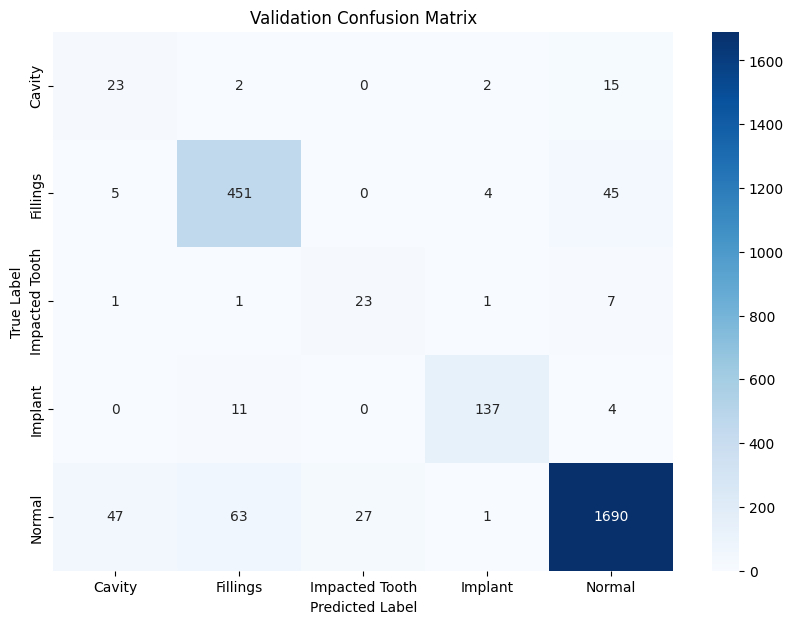


Validation Classification Report:
                precision    recall  f1-score   support

        Cavity       0.30      0.55      0.39        42
      Fillings       0.85      0.89      0.87       505
Impacted Tooth       0.46      0.70      0.55        33
       Implant       0.94      0.90      0.92       152
        Normal       0.96      0.92      0.94      1828

      accuracy                           0.91      2560
     macro avg       0.70      0.79      0.74      2560
  weighted avg       0.92      0.91      0.91      2560



In [19]:
class_names = list(train_generator.class_indices.keys())
valid_cm = confusion_matrix(valid_labels, valid_predictions)
print("Validation Confusion Matrix:")
plot_confusion_matrix(valid_cm, class_names, title='Validation Confusion Matrix')
print("\nValidation Classification Report:")
print(classification_report(valid_labels, valid_predictions, target_names=class_names))

# Confusion Matrix and Classification Report for Test

Test Confusion Matrix:


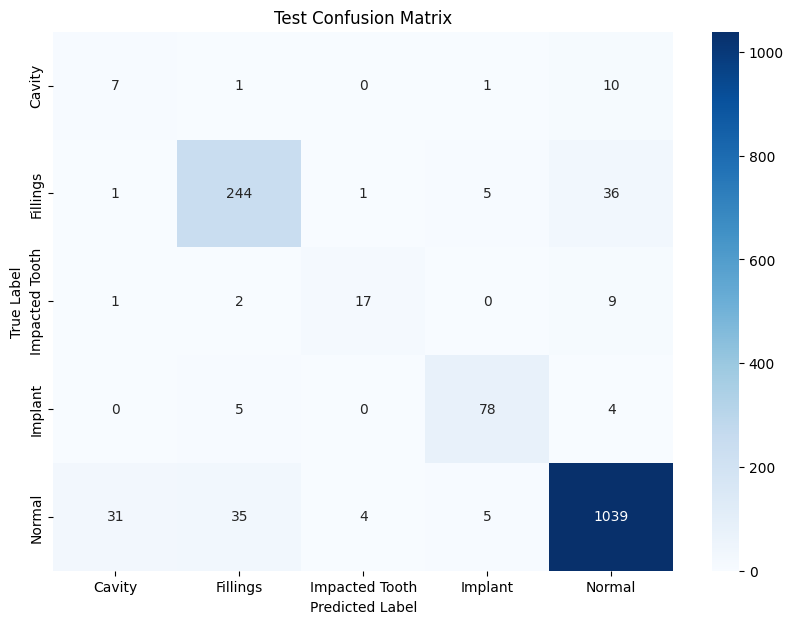


Test Classification Report:
                precision    recall  f1-score   support

        Cavity       0.17      0.37      0.24        19
      Fillings       0.85      0.85      0.85       287
Impacted Tooth       0.77      0.59      0.67        29
       Implant       0.88      0.90      0.89        87
        Normal       0.95      0.93      0.94      1114

      accuracy                           0.90      1536
     macro avg       0.72      0.73      0.72      1536
  weighted avg       0.91      0.90      0.91      1536



In [20]:
test_cm = confusion_matrix(test_labels, test_predictions)
print("Test Confusion Matrix:")
plot_confusion_matrix(test_cm, class_names, title='Test Confusion Matrix')
print("\nTest Classification Report:")
print(classification_report(test_labels, test_predictions, target_names=class_names))